# Thermodynamically Compatible Finite Volume Scheme

## Importing Libraries

In [1]:
from numpy import *
import matplotlib.pyplot as plt

## Gauss Legendre Quadrature of order n

In [2]:
# Recursive Generation of Legendre polynomial of order n

def Legendre(n, x):
  x = array(x)
  if(n == 0):
    return x*0+1.0
  elif(n == 1):
    return x
  else:
    return ((2.0*n-1.0)*x*Legendre(n-1, x) - (n-1)*Legendre(n-2, x))/n

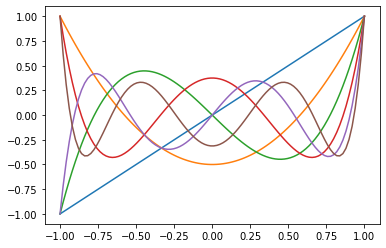

In [3]:
# Checking the Legendre Polynomial function

i = 1
x = linspace(-1,1,100)
xarr = array(x)

for i in range(1, 7):
  y = []
  for ele in x:
      # print(i, ele, Legendre(i, ele))
      y.append(Legendre(i, ele))
  yarr = array(y)
  plt.plot(xarr, yarr)
plt.show()

In [4]:
# Derivative of the Legendre polynomials

def der_Legendre(n, x):
  x = array(x);
  if(n == 0):
    return x*0
  elif(n == 1):
    return x*0+1.0
  else:
    return (n/(x**2-1.0)) * (x*Legendre(n, x) - Legendre(n-1, x))

In [5]:
# Finding the roots of the polynomial obtained using Newton-Raphson method

def roots_Legendre(poly_order, tolerance = 1e-7):
  if poly_order < 2:
    err = 1 # No roots can be found as it is a bad polynomial
  else:
    roots = []
    # The polynomials are alternatively even and odd functions. So, we need to
    # only half the number of roots.
    for i in range(1, (polyorder//2) + 1):
      x = cos(pi*(i - 0.25)/(poly_order+0.5))
      error = 10 * tolerance
      num_iters = 0
      while(error > tolerance) and (num_iters < 10000):
        dx = -Legendre(poly_order, x)/der_Legendre(poly_order, x)
        x = x + dx
        num_iters += 1
        error = abs(dx)
      if num_iters == 10000:
        print('Failed to convg')
      roots.append(x)

    # Now, we will use symmetry to get the other roots
    roots = array(roots)
    if(poly_order % 2 == 0):
      roots = concatenate((-1.0*roots, roots[::-1]))
    else:
      roots = concatenate((-1.0*roots, [0.0], roots[::-1]))
    
    err = 0 # we have successfully determined roots
    return [roots, err]


In [6]:
# Finding the weights coefficients

def weight_Legendre(poly_order):
  w = []
  [xis, err] = roots_Legendre(poly_order)
  if(err == 0):
    w = 2.0/((1.0-xis**2)*(der_Legendre(poly_order, xis) ** 2))
    err = 0
  else:
    err = 1 # no weights as we could not determine the roots
  
  return [w, xis, err]

In [7]:
# Finding the Gauss Legendre Quadrature 
# func : the function; a, b: upper & lower limits; poly_order: order of Legendre polynomial

def GaussLegendreQuadrature(func, poly_order, a, b):
  [ws, xs, err] = weight_Legendre(poly_order)
  if(err == 0):
    ans = (b-a) * 0.5 * sum(ws*func((b-a)*0.5*xs + (b+a)*0.5))
  else: # case of error
    err = 1
    ans = None
  return [ans, err]

In [8]:
# Integrand function i.e. the main function

def func(x):
  return exp(x)

In [9]:
# Running the code

polyorder = 5
[ws,xs,err] = weight_Legendre(polyorder)

if err==0:
	print("Order    : ", polyorder)
	print("Roots    : ", xs)
	print("Weights  : ", ws)
else:
	print("Roots/Weights evaluation failed")
 
# Integrating the function
[ans,err]=GaussLegendreQuadrature(func , polyorder, -3,3)
if err==0:
	print("Integral : ", ans)
else:
	print("Integral evaluation failed")

Order    :  5
Roots    :  [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
Weights  :  [0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]
Integral :  20.035577718385444


## Euler Subsystem

We'll manage our 1-d grid via a class FVGrid. We will divide the domain into a number of zones (or volumes) that will store the state. To implement boundary conditions, we traditionally use ghost cells--extra cells added to each end of the domain. We'll consider a grid that looks like this:



To make life easier, we'll have a simple class with indices that we use to index the fluid state arrays. We can pass this around and be sure that we are always accessing the correct fluid state.

In [10]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to
    refer to the different fluid components"""
    def __init__(self, gamma=1.4, C=0.8):
        self.nvar = 3
    
        # conserved variables
        self.urho = 0
        self.umx = 1
        self.uener = 2
    
        # primitive variables
        self.qrho = 0
        self.qu = 1
        self.qp = 2
    
        # EOS gamma
        self.gamma = gamma
        
        # CFL number
        self.C = C

This is the main class for managing the finite-volume grid. In addition to holding coordinate information and knowing the bounds of the domain, it also can fill the ghost cells and give you a scratch array that lives on the same grid.

In [11]:
class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.lo = ng
        self.hi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        return np.squeeze(np.zeros((self.nx+2*self.ng, nc), dtype=np.float64))

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """
        if atmp.ndim == 2:
            for n in range(atmp.shape[-1]):
                atmp[0:self.lo, n] = atmp[self.lo, n]
                atmp[self.hi+1:, n] = atmp[self.hi, n]            
        else:
            atmp[0:self.lo] = atmp[self.lo]
            atmp[self.hi+1:] = atmp[self.hi]

We need to use the cell-averages to figure out what the fluid state is on the interfaces. We'll reconstruct the cell-averages as piecewise lines that give us the same average in the zone. We then follow these lines to the interfaces to define the left and right state at each interface.
Usually we work in terms of the primitive variables, $$ q = (\rho, u, p) $$ . So we first write a routine to do the algebraic transformation from conservative to primitive variables:


In [12]:
def cons_to_prim(grid, U):
    """take a conservative state U and return the corresponding primitive
    variable state as a new array."""
    v = FluidVars()
    q = grid.scratch_array(nc=v.nvar)

    q[:, v.qrho] = U[:, v.urho]
    q[:, v.qu] = U[:, v.umx]/U[:, v.urho]
    rhoe = U[:, v.uener] - 0.5*q[:, v.qrho]*q[:, v.qu]**2
    q[:, v.qp] = rhoe*(v.gamma - 1.0)
    return q

Next we need a routine to create the interface states. Here's well construct a slope for each zone, $ Δq $  based on the average state in the neighboring zones. This gives us a line representing the value of the fluid state as a function of position in each zone:

$$ q_i(x) = <q>_i + \frac{Δq_i}{Δx} (x-x_i) $$

Note that there is a unique $ q_i(x) $
 for each zone—this is usually called piecewise linear reconstruction. By design, the average of $ q_i(x) $ over the zone is the cell-average, so it is conservative.

We use this equation for a line to find the fluid state right at the interface. For zone $ i $, the line $ q_i(x) $ gives you the right state on the left interface, $ q_{i-\frac{1}{2}, R} $
, and the left state on the right interface, $ q_{i+\frac{1}{2}, L} $
. Visually this looks like:
![image](/content/img2.png)

There's one additional wrinkle—2nd order codes tend to produce oscillations near discontinuities, so we usually need to limit the slopes, $ Δq_i $
, so we don't introduce new minima or maxima in the evolution. We'll use the minmod limiter:

Write minmod limiter

In [13]:
def states(grid, U):
    v = FluidVars()
    q = cons_to_prim(grid, U)

    # construct the slopes
    dq = grid.scratch_array(nc=v.nvar)

    for n in range(v.nvar):        
        dl = grid.scratch_array()
        dr = grid.scratch_array()

        dl[grid.lo-1:grid.hi+2] = q[grid.lo:grid.hi+3,n] - q[grid.lo-1:grid.hi+2,n]
        dr[grid.lo-1:grid.hi+2] = q[grid.lo-1:grid.hi+2,n] - q[grid.lo-2:grid.hi+1,n]

        # these where's do a minmod()
        d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
        dq[:, n] = np.where(dl*dr > 0.0, d1, 0.0)

    # now make the states
    q_l = grid.scratch_array(nc=v.nvar)
    q_l[grid.lo:grid.hi+2, :] = q[grid.lo-1:grid.hi+1, :] + 0.5*dq[grid.lo-1:grid.hi+1, :]

    q_r = grid.scratch_array(nc=v.nvar)
    q_r[grid.lo:grid.hi+2, :] = q[grid.lo:grid.hi+2, :] - 0.5*dq[grid.lo:grid.hi+2, :]
    
    return q_l, q_r